In [1]:
import csv
import subprocess
import shlex
import json

import numpy as np

from io import StringIO
from matplotlib import pyplot as plt
from scipy.stats import kstest, expon
from IPython.display import display, Markdown

In [2]:
target_directory = json.loads(subprocess.run("cargo metadata --format-version 1".split(), capture_output=True).stdout)["target_directory"]

# Speciation Time Test

In [3]:
def test_speciation_time(
    algorithm, speciation=0.001, seed=42, radius=25, sample=1.0
):
    # Configure the simulation
    # (tested on almost infinite with sigma 0 to avoid bias from coalescence)
    config = "".join("""
    (
        speciation: {speciation},
        seed: {seed},
        sample: {sample},

        algorithm: {algorithm}(),

        scenario: AlmostInfinite(
            radius: {radius},
            sigma: 0.0,
        ),

        reporters: [
            Plugin(
                library: "{target_directory}/release/deps/libnecsim_plugins_statistics.so",
                reporters: [
                    GlobalSpeciation(output: "{output_file}"),
                ],
            ),
        ],
    )
    """.format(
        target_directory=target_directory, output_file="/dev/fd/2",
        algorithm=algorithm, speciation=speciation, seed=seed, sample=sample, radius=radius,
    ).split()).replace(",)", ")").replace(",]", "]")
    
    # Run the simulation
    speciations_io = StringIO(subprocess.run(shlex.split(
        "cargo run --release --features rustcoalescence-algorithms-monolithic,"
        + f"rustcoalescence-algorithms-independent --quiet -- simulate '{config}'"
    ), check=True, capture_output=True, text=True).stderr)
        
    
    # Read in the speciation times
    speciations = []
    with speciations_io:
        reader = csv.reader(speciations_io)
        next(reader)

        for row in reader:
            speciations.append(float(row[0]))
    speciations = np.array(speciations)
    
    # Calculate in the dispersal locations
    gof = kstest(speciations, expon(loc=0.0, scale=2.0/speciation).cdf)
    
    if gof.pvalue <= 0.05:
        display(Markdown(f"## <span style='color:red'><u>{algorithm}</u></span>"))
    elif gof.pvalue <= 0.1:
        display(Markdown(f"## <span style='color:orange'>*{algorithm}*</span>"))
    else:
        display(Markdown(f"## <span style='color:green'>{algorithm}</span>"))
    
    display(Markdown("#### KS test:"))
    display(Markdown(f"\n* p-value: {gof.pvalue}\n* statistic: {gof.statistic}"))
    
    display(Markdown("#### Speciation histograms:"))
    
    # Draw the speciation time histograms
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    x = np.linspace(np.min(speciations), np.max(speciations), 1000)
    loc, scale = expon.fit(speciations)
    
    ax1.set_title(f"Individual speciation times PDF")
    ax1.set_xlabel("speciation time")
    ax1.set_ylabel("pdf")
    ax1.plot(x, expon.pdf(x, 0.0, 2.0/speciation), color='red', linewidth=2, alpha=0.5, label=f"expected: loc=0.0 lambda={speciation * 0.5}")
    ax1.hist(speciations, bins = 1000, density=True, label=f"observed: loc≈{round(loc, 3)} lambda≈{round(1.0/scale, 3)}")
    ax1.legend()
    
    ax2.set_title(f"Individual speciation times CDF")
    ax2.set_xlabel("speciation time")
    ax2.set_ylabel("cdf")
    ax2.plot(x, expon.cdf(x, 0.0, 2.0/speciation), color='red', linewidth=2, alpha=0.5, label=f"expected: loc=0.0 lambda={speciation * 0.5}")
    ax2.hist(speciations, bins = 1000, density=True, cumulative=True, label=f"observed: loc≈{round(loc, 3)} lambda≈{round(1.0/scale, 3)}")
    ax2.legend()

    plt.show()
    
    display(Markdown(f"#### Configuration:\n```rust\n{config}\n```"))

## <span style='color:green'>Classical</span>

#### KS test:


* p-value: 0.5916796011132819
* statistic: 0.0008699853589297923

#### Speciation histograms:

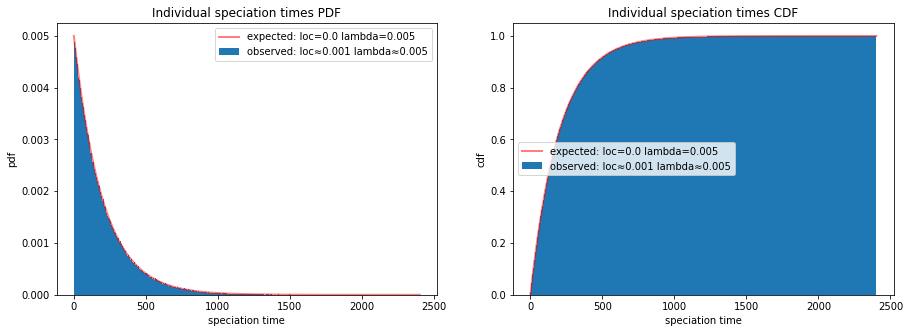

#### Configuration:
```rust
(speciation:0.01,seed:14472902443725780683,sample:1.0,algorithm:Classical(),scenario:AlmostInfinite(radius:500,sigma:0.0),reporters:[Plugin(library:"/workspace/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalSpeciation(output:"/dev/fd/2")])])
```

## <span style='color:red'><u>Gillespie</u></span>

#### KS test:


* p-value: 0.03397437158258687
* statistic: 0.001610555480349829

#### Speciation histograms:

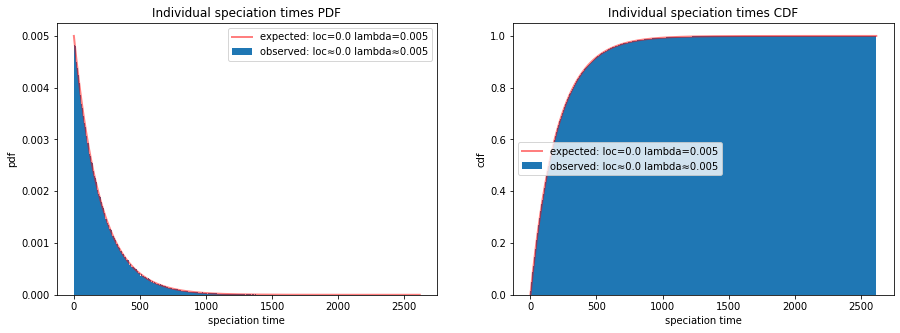

#### Configuration:
```rust
(speciation:0.01,seed:17480024017978023702,sample:1.0,algorithm:Gillespie(),scenario:AlmostInfinite(radius:500,sigma:0.0),reporters:[Plugin(library:"/workspace/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalSpeciation(output:"/dev/fd/2")])])
```

## <span style='color:green'>SkippingGillespie</span>

#### KS test:


* p-value: 0.4373151538964931
* statistic: 0.000980079092964381

#### Speciation histograms:

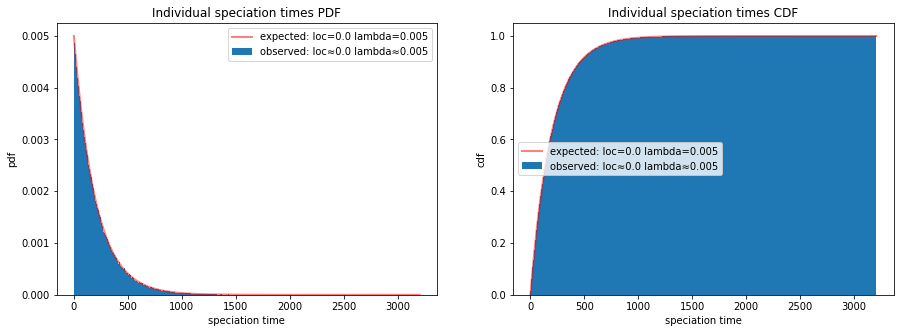

#### Configuration:
```rust
(speciation:0.01,seed:17165144267202641867,sample:1.0,algorithm:SkippingGillespie(),scenario:AlmostInfinite(radius:500,sigma:0.0),reporters:[Plugin(library:"/workspace/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalSpeciation(output:"/dev/fd/2")])])
```

## <span style='color:green'>Independent</span>

#### KS test:


* p-value: 0.5242082812772388
* statistic: 0.000916439680184622

#### Speciation histograms:

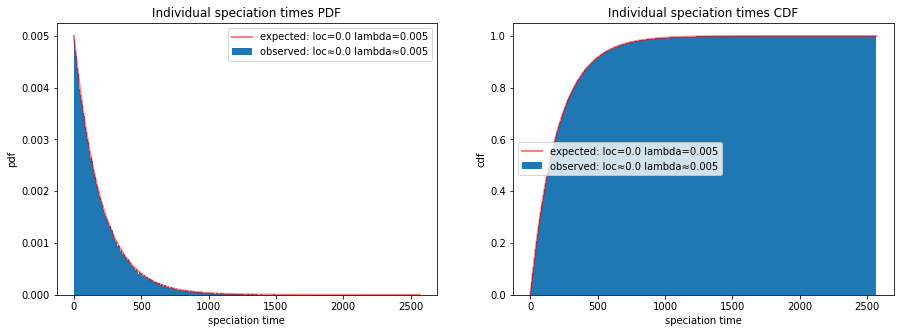

#### Configuration:
```rust
(speciation:0.01,seed:716705740304708988,sample:1.0,algorithm:Independent(),scenario:AlmostInfinite(radius:500,sigma:0.0),reporters:[Plugin(library:"/workspace/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalSpeciation(output:"/dev/fd/2")])])
```

In [4]:
for algorithm in ["Classical", "Gillespie", "SkippingGillespie", "Independent"]:
    seed = np.random.randint(0, np.iinfo("uint64").max, dtype="uint64")
    
    test_speciation_time(algorithm, speciation=0.01, seed=seed, radius=500, sample=1.0)